In [32]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI 
from dotenv import load_dotenv  
import os

In [33]:
load_dotenv()  # take environment variables from .env.

True

In [34]:
subgraph_llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0, google_api_key=os.getenv("GOOGLE_API_KEY"))

In [35]:
class SubState(TypedDict):
    eng_text: str
    hindi_text: str

In [36]:
def translate_to_hindi(state: SubState) -> SubState:
    prompt = f"Translate the following English text to Hindi:\n\n{state['eng_text']}\n\nHindi Translation:"
    hindi_text = subgraph_llm.invoke(prompt)
    return {"hindi_text": hindi_text}

In [37]:
sub_graph_builder = StateGraph(SubState)

sub_graph_builder.add_node("translate_to_hindi", translate_to_hindi)

sub_graph_builder.add_edge(START, "translate_to_hindi")
sub_graph_builder.add_edge("translate_to_hindi", END)


In [38]:
sub_graph = sub_graph_builder.compile()

In [39]:
class ParentState(TypedDict):
    question: str
    eng_text: str
    hindi_text: str

In [40]:
parent_llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0, google_api_key=os.getenv("GOOGLE_API_KEY"))

In [41]:
def generate_english_text(state: ParentState) -> ParentState:
    prompt = f"Generate a detailed answer in English for the following question:\n\n{state['question']}\n\nAnswer:"
    eng_text = parent_llm.invoke(prompt)
    return {"eng_text": eng_text}

In [42]:
def translate_answer(state: ParentState) -> ParentState:
    result = sub_graph.invoke({"eng_text": state["eng_text"]})
    return {"hindi_text": result["hindi_text"]}

In [43]:
parent_builder = StateGraph(ParentState)
parent_builder.add_node("generate_english_text", generate_english_text)
parent_builder.add_node("translate_answer", translate_answer)

parent_builder.add_edge(START, "generate_english_text")
parent_builder.add_edge("generate_english_text", "translate_answer")
parent_builder.add_edge("translate_answer", END)


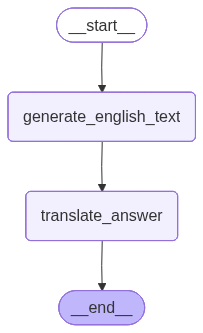

In [44]:
graph = parent_builder.compile()
graph

In [45]:
question = {
    "question": "Explain the theory of relativity."
}

result = graph.invoke(question)

In [46]:
result

{'question': 'Explain the theory of relativity.',
 'eng_text': AIMessage(content='The Theory of Relativity, developed by Albert Einstein at the beginning of the 20th century, is one of the most significant scientific theories in history. It revolutionized our understanding of space, time, gravity, and the universe itself, fundamentally challenging the classical Newtonian view of physics. The theory is composed of two main interconnected parts: **Special Relativity** (1905) and **General Relativity** (1915).\n\n---\n\n### I. Special Relativity (SR)\n\nSpecial Relativity deals with the relationship between space and time for objects moving at constant speeds relative to each other, in the absence of gravity. It is built upon two fundamental postulates:\n\n1.  **The Principle of Relativity:** The laws of physics are the same for all observers in uniform motion (i.e., moving at a constant velocity without acceleration) relative to one another. These are called "inertial frames of reference